# Artificial Intelligence Engineer Nanodegree - Probabilistic Models

Solution by Carsten Isert, 11.8.2017

## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [13]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [14]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [15]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [16]:
from asl_utils import test_features_tryit
# Add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']

asl.df.head()  # three more features mentioned above are now in the frames dictionary

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx  grnd-ly  
video frame                                      
98    0          113        9      -12      119  
      1          113        9      -12      119  
      2          113        9      -12      119  
      3          113        9      -12      119  
      4          113        9      -12      119

In [17]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [18]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [8]:
#training.get_word_Xlengths('BOOK')
words = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
#print(words)
for word in words:
    print(word, len(words))
    
cX, cLen = Xlengths['WRITE']
print(cX)

JOHN 112
WRITE 112
HOMEWORK 112
IX-1P 112
SEE 112
YESTERDAY 112
IX 112
LOVE 112
MARY 112
CAN 112
GO 112
GO1 112
FUTURE 112
GO2 112
PARTY 112
FUTURE1 112
HIT 112
BLAME 112
FRED 112
FISH 112
WONT 112
EAT 112
BUT 112
CHICKEN 112
VEGETABLE 112
CHINA 112
PEOPLE 112
PREFER 112
BROCCOLI 112
LIKE 112
LEAVE 112
SAY 112
BUY 112
HOUSE 112
KNOW 112
CORN 112
CORN1 112
THINK 112
NOT 112
PAST 112
LIVE 112
CHICAGO 112
CAR 112
SHOULD 112
DECIDE 112
VISIT 112
MOVIE 112
WANT 112
SELL 112
TOMORROW 112
NEXT-WEEK 112
NEW-YORK 112
LAST-WEEK 112
WILL 112
FINISH 112
ANN 112
READ 112
BOOK 112
CHOCOLATE 112
FIND 112
SOMETHING-ONE 112
POSS 112
BROTHER 112
ARRIVE 112
HERE 112
GIVE 112
MAN 112
NEW 112
COAT 112
WOMAN 112
GIVE1 112
HAVE 112
FRANK 112
BREAK-DOWN 112
SEARCH-FOR 112
WHO 112
WHAT 112
LEG 112
FRIEND 112
CANDY 112
BLUE 112
SUE 112
BUY1 112
STOLEN 112
OLD 112
STUDENT 112
VIDEOTAPE 112
BORROW 112
MOTHER 112
POTATO 112
TELL 112
BILL 112
THROW 112
APPLE 112
NAME 112
SHOOT 112
SAY-1P 112
SELF 112
GROUP 112
JANA

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [19]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-lx,grnd-ly
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,31.216447,157.036848
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,2.006318,104.026144
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,12.895536,118.505134


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [20]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx  grnd-ly  left-x-mean  
video frame                                                   
98    0          113        9      -12      119   164.661438  
      1          113        9      -12      119   164.661438  
      2          113        9      -12      119   164.661438  
      3          113        9      -12      119   164.661438  
      4          113        9      -12      119   164.661438

##### Try it!

In [21]:
from asl_utils import test_std_tryit
# Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-lx,grnd-ly,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,15.080360,36.572749,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,17.328941,27.117393,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,15.050938,29.320655,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [22]:
# Add features for normalized by speaker values of left, right, x, y to the dataframe
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X - Xmean) / Xstd

asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['speaker'].map(df_means['right-x'])) / asl.df['speaker'].map(df_std['right-x'])
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['speaker'].map(df_means['right-y'])) / asl.df['speaker'].map(df_std['right-y'])
asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['speaker'].map(df_means['left-x'])) / asl.df['speaker'].map(df_std['left-x'])
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['speaker'].map(df_means['left-y'])) / asl.df['speaker'].map(df_std['left-y'])

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx  grnd-ly  left-x-mean   norm-rx  \
video frame                                                              
98    0          113        9      -12      119   164.661438  1.153232   
      1          113        9      -12      119   164.661438  1.153232   
      2          113        9      -12      119   164.661438  1.153232   
      3          113        9      -12      119   164.661438  1.153232   
      4          113        9      -12      119   164.661438  1.153232   

              norm-ry   norm-lx   norm-ly  
video frame                                
98    0      1.663433 -0.891199  0.741835  
      1      1.663433 -0.891199  0.741835  
      2      1.663433 -0.891199  0.741835  
      3      1.663433 -0.891199  0.741835  
      4      1.663433 -0.891199  0.741835

In [23]:
# Add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
# Note that the x- and y-coordinates are swapped as mentioned in the description
# to move the 0 - 2pi wrap around above the speakers head.
# As the nose is the reference point, deltas have to be computed starting with
# nose as the first coordinate.

asl.df['polar-rr'] = np.sqrt(asl.df['grnd-rx']**2 + asl.df['grnd-ry']**2)
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])

asl.df['polar-lr'] = np.sqrt(asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx  grnd-ly  left-x-mean   norm-rx  \
video frame                                                              
98    0          113        9      -12      119   164.661438  1.153232   
      1          113        9      -12      119   164.661438  1.153232   
      2          113        9      -12      119   164.661438  1.153232   
      3          113        9      -12      119   164.661438  1.153232   
      4          113        9      -12      119   164.661438  1.153232   

              norm-ry   norm-lx   norm-ly   polar-rr  polar-rtheta  \
video frame                                                          
98    0      1.663433 -0.891199  0.741835  113.35784      0.079478   
      1      1.663433 -0.891199  0.741835  113.35784      0.079478   
      2      1.663433 -0.891199  0.741835  113.35784      0.079478   
      3      1.663433 -0.891199  0.741835  113.35784      0.079478   
      4      1.663433 -0.891199  0.741835  113.35784      0.079478   

               polar-lr  polar-ltheta  
video frame                            
98    0      119.603512     -0.100501  
      1      119.603512     -0.100501  
      2      119.603512     -0.100501  
      3      119.603512     -0.100501  
      4      119.603512     -0.100501

In [24]:
# Add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0)
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx    ...      norm-lx   norm-ly  \
video frame                               ...                          
98    0          113        9      -12    ...    -0.891199  0.741835   
      1          113        9      -12    ...    -0.891199  0.741835   
      2          113        9      -12    ...    -0.891199  0.741835   
      3          113        9      -12    ...    -0.891199  0.741835   
      4          113        9      -12    ...    -0.891199  0.741835   

              polar-rr  polar-rtheta    polar-lr  polar-ltheta  delta-rx  \
video frame                                                                
98    0      113.35784      0.079478  119.603512     -0.100501       0.0   
      1      113.35784      0.079478  119.603512     -0.100501       0.0   
      2      113.35784      0.079478  119.603512     -0.100501       0.0   
      3      113.35784      0.079478  119.603512     -0.100501       0.0   
      4      113.35784      0.079478  119.603512     -0.100501       0.0   

             delta-ry  delta-lx  delta-ly  
video frame                                
98    0           0.0       0.0       0.0  
      1           0.0       0.0       0.0  
      2           0.0       0.0       0.0  
      3           0.0       0.0       0.0  
      4           0.0       0.0       0.0  

[5 rows x 24 columns]

In [25]:
# Add features of my own design: Detailed description and motivation: See below in answer to question 1

# Should be based on normalized data, so we need to recompute the
# mean and variance for the new values we added.
df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()

asl.df['grnd-norm-rx'] = (asl.df['grnd-rx'] - asl.df['speaker'].map(df_means['grnd-rx'])) / asl.df['speaker'].map(df_std['grnd-rx'])
asl.df['grnd-norm-ry'] = (asl.df['grnd-ry'] - asl.df['speaker'].map(df_means['grnd-ry'])) / asl.df['speaker'].map(df_std['grnd-ry'])
asl.df['grnd-norm-lx'] = (asl.df['grnd-lx'] - asl.df['speaker'].map(df_means['grnd-lx'])) / asl.df['speaker'].map(df_std['grnd-lx'])
asl.df['grnd-norm-ly'] = (asl.df['grnd-ly'] - asl.df['speaker'].map(df_means['grnd-ly'])) / asl.df['speaker'].map(df_std['grnd-ly'])

asl.df['delta-grnd-norm-rx'] = asl.df['grnd-norm-rx'].diff().fillna(0)
asl.df['delta-grnd-norm-ry'] = asl.df['grnd-norm-ry'].diff().fillna(0)
asl.df['delta-grnd-norm-lx'] = asl.df['grnd-norm-lx'].diff().fillna(0)
asl.df['delta-grnd-norm-ly'] = asl.df['grnd-norm-ly'].diff().fillna(0)

features_custom = ['delta-grnd-norm-rx', 'delta-grnd-norm-ry', 'delta-grnd-norm-lx', 'delta-grnd-norm-ly']

asl.df.head()



left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx         ...          delta-lx  \
video frame                                    ...                     
98    0          113        9      -12         ...               0.0   
      1          113        9      -12         ...               0.0   
      2          113        9      -12         ...               0.0   
      3          113        9      -12         ...               0.0   
      4          113        9      -12         ...               0.0   

             delta-ly  grnd-norm-rx  grnd-norm-ry  grnd-norm-lx  grnd-norm-ly  \
video frame                                                                     
98    0           0.0      1.230994      1.557506     -0.808262      0.552186   
      1           0.0      1.230994      1.557506     -0.808262      0.552186   
      2           0.0      1.230994      1.557506     -0.808262      0.552186   
      3           0.0      1.230994      1.557506     -0.808262      0.552186   
      4           0.0      1.230994      1.557506     -0.808262      0.552186   

             delta-grnd-norm-rx  delta-grnd-norm-ry  delta-grnd-norm-lx  \
video frame                                                               
98    0                     0.0                 0.0                 0.0   
      1                     0.0                 0.0                 0.0   
      2                     0.0                 0.0                 0.0   
      3                     0.0                 0.0                 0.0   
      4                     0.0                 0.0                 0.0   

             delta-grnd-norm-ly  
video frame                      
98    0                     0.0  
      1                     0.0  
      2                     0.0  
      3                     0.0  
      4                     0.0  

[5 rows x 32 columns]

In [26]:
# After evaluating part 3 the polar feature set was performing quite well, so I give it another try 
# by generating another custom feature set with normalized polar coordinates.

# Should be based on normalized data, so we need to recompute the
# mean and variance for the polar coordinates.
df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()

asl.df['polar-norm-rr'] = (asl.df['polar-rr'] - asl.df['speaker'].map(df_means['polar-rr'])) / asl.df['speaker'].map(df_std['polar-rr'])
asl.df['polar-norm-lr'] = (asl.df['polar-lr'] - asl.df['speaker'].map(df_means['polar-lr'])) / asl.df['speaker'].map(df_std['polar-lr'])
# The angles do not need to be normalized: will use polar-rtheta and polar-ltheta

asl.df['delta-polar-norm-rr'] = asl.df['polar-norm-rr'].diff().fillna(0)
asl.df['delta-polar-norm-lr'] = asl.df['polar-norm-lr'].diff().fillna(0)
asl.df['delta-polar-norm-rtheta'] = asl.df['polar-rtheta'].diff().fillna(0)
asl.df['delta-polar-norm-ltheta'] = asl.df['polar-ltheta'].diff().fillna(0)

features_polar_norm = ['polar-norm-rr', 'polar-norm-lr', 'polar-rtheta', 'polar-ltheta']
features_polar_norm_ext = features_polar_norm + ['delta-polar-norm-rr', 'delta-polar-norm-lr', 'delta-polar-norm-rtheta', 'delta-polar-norm-ltheta']

print(features_polar_norm_ext)

asl.df.head()

['polar-norm-rr', 'polar-norm-lr', 'polar-rtheta', 'polar-ltheta', 'delta-polar-norm-rr', 'delta-polar-norm-lr', 'delta-polar-norm-rtheta', 'delta-polar-norm-ltheta']


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx           ...             \
video frame                                      ...              
98    0          113        9      -12           ...              
      1          113        9      -12           ...              
      2          113        9      -12           ...              
      3          113        9      -12           ...              
      4          113        9      -12           ...              

             delta-grnd-norm-rx  delta-grnd-norm-ry  delta-grnd-norm-lx  \
video frame                                                               
98    0                     0.0                 0.0                 0.0   
      1                     0.0                 0.0                 0.0   
      2                     0.0                 0.0                 0.0   
      3                     0.0                 0.0                 0.0   
      4                     0.0                 0.0                 0.0   

             delta-grnd-norm-ly  polar-norm-rr  polar-norm-lr  \
video frame                                                     
98    0                     0.0       1.573439       0.542499   
      1                     0.0       1.573439       0.542499   
      2                     0.0       1.573439       0.542499   
      3                     0.0       1.573439       0.542499   
      4                     0.0       1.573439       0.542499   

             delta-polar-norm-rr  delta-polar-norm-lr  \
video frame                                             
98    0                      0.0                  0.0   
      1                      0.0                  0.0   
      2                      0.0                  0.0   
      3                      0.0                  0.0   
      4                      0.0                  0.0   

             delta-polar-norm-rtheta  delta-polar-norm-ltheta  
video frame                                                    
98    0                          0.0                      0.0  
      1                          0.0                      0.0  
      2                          0.0                      0.0  
      3                          0.0                      0.0  
      4                          0.0                      0.0  

[5 rows x 38 columns]

In [16]:
sample = (asl.df.ix[98, 12][features_custom]).tolist()
print(sample)

[-0.11929824713430226, -0.2354834732056641, 0.0, 0.0]


**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** Based on the material from the videos and the features computed in this notebook, it seems to be a good idea to normalize the data so the differences between the different speakers will not effect the further analysis.
I think it is also important from an analytical point of view, to consider the relative position between the hands and the nose. This is directly indicated by the ground values computed in the tutorial.
So I computed the normalized ground values in the same manner as for the normalized x and y coordinates.
To facilitate the analysis by the HMM as done in the lectures, I thought it would be a could idea to look at the delta values in time between the normalized ground values.

As the conversion to polar coordinates is just a transformation which doesn't capture the movements naturally, I decided to stay with cartesian coordinates for the intial set.

Update after analysis in part 2: Based on the experiments and the benchmarking with the different feature sets, the custom feautre set described above outperformed the other feature sets for the 5 test words from part 2 for the CV model selector and the BIC model selector.
As the influence of the adversarial words can be extremely high for the DIC case, it is more difficult to compare feature sets. See more details answered for question 2.

Update after analysis in part 3: After evaluating part 3 the polar feature set was performing quite well, so I give it another try by generating another custom feature set with normalized polar coordinates and also an extended one which includes 8 rather than 4 features.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [17]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.014s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [29]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    print("Lengths: ", lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_polar_norm)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Lengths:  [6, 6, 7, 7, 11, 8, 8, 8, 7, 8, 17, 15, 13, 14, 11, 8, 10, 8]
Number of states trained in model for BOOK is 3
logL = 355.93185660337457


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [30]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [-0.27097391 -1.99402345 -0.09662616  0.21162247]
variance =  [ 0.01045017  0.04665929  0.00705612  0.00543995]

hidden state #1
mean =  [-0.64273147 -2.53686594 -0.02692854  0.28700191]
variance =  [ 0.02579744  0.09863813  0.02576175  0.01288738]

hidden state #2
mean =  [ 0.16825934 -1.46228119 -0.13818583  0.15566012]
variance =  [ 0.07644872  0.08555853  0.00680972  0.00233434]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [20]:
my_testword = 'TEACHER'
for i in range(5,7):
    model, logL = train_a_word(my_testword, i, features_custom) # Experiment here with different parameters
    #show_model_stats(my_testword, model)
    print("logL = {}".format(logL))

Lengths:  [11, 11, 12, 22]
logL = 192.693514612426
Lengths:  [11, 11, 12, 22]
logL = 200.30371011052878


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [31]:
%matplotlib inline

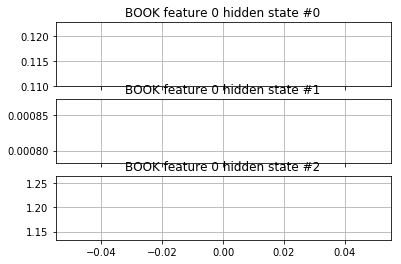

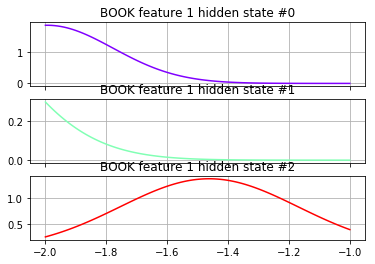

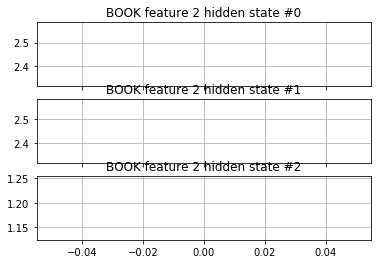

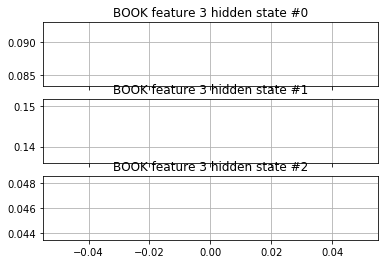

In [32]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()

my_testword = 'BOOK'
visualize(my_testword, model)

# NOTE: Visualizations often not showing any data

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [24]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [33]:
from sklearn.model_selection import KFold
import asl_utils

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'BOOK' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds
    cv_train_X, cv_train_lengths = asl_utils.combine_sequences(cv_train_idx, word_sequences)

Train fold indices:[ 6  7  8  9 10 11 12 13 14 15 16 17] Test fold indices:[0 1 2 3 4 5]
Train fold indices:[ 0  1  2  3  4  5 12 13 14 15 16 17] Test fold indices:[ 6  7  8  9 10 11]
Train fold indices:[ 0  1  2  3  4  5  6  7  8  9 10 11] Test fold indices:[12 13 14 15 16 17]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [34]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
#words_to_train = ['SAY-1P', 'LEG', 'ANN']
#words_to_train = ['SAY-1P', 'FIND']

import timeit

In [134]:
# This ensures that the code from the files is reloaded every 2s so that
# the changes actually take effect.
%load_ext autoreload
%autoreload 2

# Implemented SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
FISH : Best CV: 216.537577344
Training complete for FISH with 7 states with time 2.117584521009121 seconds
BOOK : Best CV: 199.339754658
Training complete for BOOK with 8 states with time 15.978637291991618 seconds
VEGETABLE : Best CV: 180.324556249
Training complete for VEGETABLE with 2 states with time 7.737274023995269 seconds
FUTURE : Best CV: 160.068816784
Training complete for FUTURE with 3 states with time 19.30028335697716 seconds
JOHN : Best CV: 3140.31800948
Training complete for JOHN with 9 states with time 149.7268623400014 seconds


In [56]:
# This ensures that the code from the files is reloaded every 2s so that
# the changes actually take effect.
%load_ext autoreload
%autoreload 2

# Implemented SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_delta)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
FISH  BIC  -306.178797522
Training complete for FISH with 4 states with time 0.3114097249926999 seconds
BOOK  BIC  1662.82225519
Training complete for BOOK with 3 states with time 2.9254831969738007 seconds
VEGETABLE  BIC  -1216.65868044
Training complete for VEGETABLE with 3 states with time 0.8399584949947894 seconds
FUTURE  BIC  642.924743221
Training complete for FUTURE with 5 states with time 2.0538319530314766 seconds
JOHN  BIC  -1583.74874947
Training complete for JOHN with 6 states with time 27.554160750994924 seconds


In [36]:
# This ensures that the code from the files is reloaded every 2s so that
# the changes actually take effect.
%load_ext autoreload
%autoreload 2

# SelectorDIC is implemented in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_polar_norm_ext)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
FISH : Best DIC 20005.1580144  with alpha  1.0
Training complete for FISH with 2 states with time 2.6569719290127978 seconds
BOOK : Best DIC 6561.60272581  with alpha  1.0
Training complete for BOOK with 15 states with time 4.303440493997186 seconds
VEGETABLE : Best DIC 15588.9807255  with alpha  1.0
Training complete for VEGETABLE with 5 states with time 2.8962452560081147 seconds
FUTURE : Best DIC 2176.63140129  with alpha  1.0
Training complete for FUTURE with 15 states with time 3.7981521310284734 seconds
JOHN : Best DIC 13536.029871  with alpha  1.0
Training complete for JOHN with 15 states with time 34.28904301702278 seconds


#### **Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**
The performances of all model selectors have been evaluated with all feature sets and documented in the Excel file performance_benchmarking.xlsx.

Here are several observations:
1. Generally, it is very interesting to observe, that each evaluation criteria generates totally different models with a wide range of states, often covering both the minimum and maximum number of states depending on the features and selector. Intuition would tell us that it is better to have most states not as corner cases.
2. The performance values of the different feature sets could be transferred to the performance after the selection process. The performance of the custom feature set was generally better than the performance of the other feature sets when looking at the average values of the performance.
3. BIC: There was still some uncertainty about the exact formula to compute the number of free parameters. Please provide feedback if there was an error.
4. BIC: This selector generally selected models with few states, often even only 2 states. This seems not appropriate to model more complex sign language words. Especially for the custom features the states where mostly 2.
5. BIC: It is a little bit strange that the model for JOHN was modelled with few states. The reason is that there are a lot of datapoints compared to the other words and this generates a huge penalty.
6. DIC: Compared to the score of the word to test, the discriminating scores of the other words can have much higher values and lead to a totally different evaluation.
7. DIC: In the paper describing the DIC, a factor alpha was introduced to control the influence of the competing words on the score. This was not included in the formula in the code. According to the paper, low values of alpha performed much better. I implemented it and evaluated it for the custom features, but I didn't see a strong influence on the selection of the number of states in the model. 
8. DIC: This selector chose the models with the most number of states, often selecting the maximum of 15 states. Generally, I would expect that this is not the optimal strategy.
9. CV: There were only 2 datapoints for FISH, so the model for this word could not be computed with CV. So the simple log score was used.
10. CV: The number of states for CV were less extremely distributed than for the other selectors.
11. Runtime: The time to compute the models using the different selectors was still in the range of seconds and as this only happens in the training phase no special analysis was required.



<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [121]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

FRANK : BIC  480.306704139


.

VEGETABLE : BIC  701.692705759


.

JOHN : Best CV: -2907.75082578


.

CHICKEN : Best CV: 25.0864417724
MARY : Best DIC -3078.06170989  with alpha  0.1


.

TOY : Best DIC 875.036082938  with alpha  0.1



----------------------------------------------------------------------
Ran 4 tests in 138.150s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for your experimentation and final submission cells.



In [37]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=4).select()
        model_dict[word]=model
    return model_dict

#models = train_all_words(features_ground, SelectorConstant)
#print("Number of word models returned = {}".format(len(models)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [91]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))
test_set.sentences_index

Number of test set items: 178
Number of test set sentences: 40


{2: [0, 1, 2],
 7: [3, 4, 5, 6],
 12: [7, 8, 9, 10],
 21: [11, 12, 13, 14, 15, 16, 17, 18],
 25: [19, 20, 21, 22, 23],
 28: [24, 25, 26, 27, 28],
 30: [29, 30, 31, 32, 33],
 36: [34, 35, 36, 37, 38, 39],
 40: [40, 41, 42, 43, 44],
 43: [45, 46, 47, 48],
 50: [49, 50, 51, 52, 53],
 54: [54, 55, 56, 57, 58],
 57: [59, 60, 61, 62],
 67: [63, 64, 65, 66, 67],
 71: [68, 69, 70, 71],
 74: [72, 73, 74, 75],
 77: [76, 77, 78],
 84: [79, 80, 81, 82],
 89: [83, 84, 85, 86, 87, 88, 89],
 90: [90, 91, 92, 93, 94, 95],
 92: [96, 97, 98, 99, 100, 101],
 100: [102, 103, 104, 105],
 105: [106, 107],
 107: [108, 109, 110, 111, 112],
 108: [113, 114],
 113: [115, 116, 117, 118, 119],
 119: [120, 121, 122, 123, 124],
 122: [125, 126, 127],
 139: [128, 129, 130, 131, 132],
 142: [133, 134, 135, 136, 137],
 158: [138, 139, 140],
 167: [141, 142, 143, 144, 145],
 171: [146, 147, 148],
 174: [149, 150, 151, 152, 153],
 181: [154, 155],
 184: [156, 157, 158, 159, 160],
 189: [161, 162, 163, 164],
 193: [165, 

In [95]:
index = 0
test_X, test_length = test_set.get_item_Xlengths(index)
print(test_X)
print(test_set.wordlist[index])

start_markers = []
for sentence in test_set.sentences_index:
    sentence_seq = test_set.sentences_index[sentence]
    print(sentence_seq)
    start_markers.append(sentence_seq[0])
print(start_markers)

[[  1  58 -12 122]
 [ -6  53 -12 122]
 [ -9  45 -12 122]
 [-13  38 -12 122]
 [-14  34 -12 122]
 [-13  29 -12 122]
 [-18  25 -12 122]
 [-20  25 -12 122]
 [-22  22 -12 122]
 [-18  18 -11 120]
 [-20  22  -8 117]
 [-19  18  -9 117]
 [-15  22  -5 100]
 [-12  26   0  93]]
JOHN
[0, 1, 2]
[3, 4, 5, 6]
[7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18]
[19, 20, 21, 22, 23]
[24, 25, 26, 27, 28]
[29, 30, 31, 32, 33]
[34, 35, 36, 37, 38, 39]
[40, 41, 42, 43, 44]
[45, 46, 47, 48]
[49, 50, 51, 52, 53]
[54, 55, 56, 57, 58]
[59, 60, 61, 62]
[63, 64, 65, 66, 67]
[68, 69, 70, 71]
[72, 73, 74, 75]
[76, 77, 78]
[79, 80, 81, 82]
[83, 84, 85, 86, 87, 88, 89]
[90, 91, 92, 93, 94, 95]
[96, 97, 98, 99, 100, 101]
[102, 103, 104, 105]
[106, 107]
[108, 109, 110, 111, 112]
[113, 114]
[115, 116, 117, 118, 119]
[120, 121, 122, 123, 124]
[125, 126, 127]
[128, 129, 130, 131, 132]
[133, 134, 135, 136, 137]
[138, 139, 140]
[141, 142, 143, 144, 145]
[146, 147, 148]
[149, 150, 151, 152, 153]
[154, 155]
[156, 157, 158, 159, 16

<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [39]:
# Implemented the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [100]:
# For Ground features DIC performed best
features = features_ground # change as needed
model_selector = SelectorDIC # change as needed

# Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

JOHN : Best CV: -6423.45262285
WRITE : Best CV: -186.459409677
HOMEWORK : Best CV: -215.329028803
IX-1P : Best CV: -352.73297734
SEE : Best CV: -772.400907924
YESTERDAY : Best CV: -696.734356767
IX : Best CV: -3276.02460997
LOVE : Best CV: -1029.9922233
MARY : Best CV: -2877.05651639
CAN : Best CV: -785.412759513
GO : Best CV: -587.937666285
GO1 : Best CV: -240.294492148
FUTURE : Best CV: -823.622325721
GO2 : Best CV: 5.50869706537
PARTY : Best CV: 9.07093048904
FUTURE1 : Best CV: 31.3606949101
HIT : Best CV: -21.2706645323
BLAME : Best CV: -533.937694168
FRED : Best CV: -32.7054266183
FISH : Best CV: 129.629479206
WONT : Best CV: -140.454097381
EAT : Best CV: -497.075087405
BUT : Best CV: 55.2253191635
CHICKEN : Best CV: -33.194112336
VEGETABLE : Best CV: -733.102980665
CHINA : Best CV: 185.380009524
PEOPLE : Best CV: -309.345509212
PREFER : Best CV: -1006.57266447
BROCCOLI : Best CV: 36.9900307796
LIKE : Best CV: -404.124060099
LEAVE : Best CV: 85.4909157399
SAY : Best CV: 47.7309160

In [106]:
# Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorDIC # change as needed

# Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


JOHN : Best DIC -4696.59726138  with alpha  1.0
WRITE : Best DIC 144358.063938  with alpha  1.0
HOMEWORK : Best DIC 4959.08153074  with alpha  1.0
IX-1P : Best DIC 23832.4639598  with alpha  1.0
SEE : Best DIC 13911.7254161  with alpha  1.0
YESTERDAY : Best DIC 2626.28053171  with alpha  1.0
IX : Best DIC -1097.38658253  with alpha  1.0
LOVE : Best DIC 1707.56080912  with alpha  1.0
MARY : Best DIC -1115.17068582  with alpha  1.0
CAN : Best DIC 2407.97411559  with alpha  1.0
GO : Best DIC 1275.86617159  with alpha  1.0
GO1 : Best DIC 15916.1396366  with alpha  1.0
FUTURE : Best DIC 2308.64163304  with alpha  1.0
GO2 : Best DIC 18682.6795445  with alpha  1.0
PARTY : Best DIC 601556.551219  with alpha  1.0
FUTURE1 : Best DIC 74117.0390402  with alpha  1.0
HIT : Best DIC 271792.617962  with alpha  1.0
BLAME : Best DIC 1412.70475989  with alpha  1.0
FRED : Best DIC 8856252.25282  with alpha  1.0
FISH : Best DIC 7818900.59583  with alpha  1.0
WONT : Best DIC 7749.81327352  with alpha  1.0
E

In [41]:
# Choose a feature set and model selector
features = features_polar_norm_ext # change as needed
model_selector = SelectorDIC # change as needed

# Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

JOHN : Best DIC 12647.2563634  with alpha  1.0
WRITE : Best DIC 7552.89445879  with alpha  1.0
HOMEWORK : Best DIC 4832.67437621  with alpha  1.0
IX-1P : Best DIC 11231.7176309  with alpha  1.0
SEE : Best DIC 10323.7212428  with alpha  1.0
YESTERDAY : Best DIC 3229.77106189  with alpha  1.0
IX : Best DIC 5521.60386152  with alpha  1.0
LOVE : Best DIC 2860.21165601  with alpha  1.0
MARY : Best DIC 5672.46670642  with alpha  1.0
CAN : Best DIC 2833.8068467  with alpha  1.0
GO : Best DIC 1461.97158805  with alpha  1.0
GO1 : Best DIC 7077.05169446  with alpha  1.0
FUTURE : Best DIC 2163.10534754  with alpha  1.0
GO2 : Best DIC 12869.2639011  with alpha  1.0
PARTY : Best DIC 14958.3450464  with alpha  1.0
FUTURE1 : Best DIC 16301.3852027  with alpha  1.0
HIT : Best DIC 10275.5176997  with alpha  1.0
BLAME : Best DIC 2143.74425335  with alpha  1.0
FRED : Best DIC 13544.1888778  with alpha  1.0
FISH : Best DIC 20005.1580144  with alpha  1.0
WONT : Best DIC 3325.28335292  with alpha  1.0
EAT :

In [136]:
# Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorConstant # change as needed

# Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

Now evaluating scores for word:  JOHN
Best guess:  JOHN  with score:  83.7952406887
Now evaluating scores for word:  WRITE
Best guess:  IX  with score:  44.1199324747
Now evaluating scores for word:  HOMEWORK
Best guess:  HOMEWORK  with score:  53.8506712195
Now evaluating scores for word:  JOHN
Best guess:  JOHN  with score:  140.397075594
Now evaluating scores for word:  CAN
Best guess:  VISIT  with score:  9.27572559112
Now evaluating scores for word:  GO
Best guess:  GO  with score:  -2.79595639867
Now evaluating scores for word:  CAN
Best guess:  TEACHER  with score:  13.5482145356
Now evaluating scores for word:  JOHN
Best guess:  JOHN  with score:  30.8938030756
Now evaluating scores for word:  CAN
Best guess:  CAN  with score:  11.3476665306
Now evaluating scores for word:  GO
Best guess:  GO1  with score:  15.2609968916
Now evaluating scores for word:  CAN
Best guess:  CAN  with score:  52.3570859468
Now evaluating scores for word:  JOHN
Best guess:  JOHN  with score:  139.998

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

The following table shows the performance of the different combinations.
In addition, the selector with constant number of states was also included.
Several selectors could not reach significantly better performance than the constant selector with ground features.

|Features | Model Selector | WER    | Correct Words |
|---------------------------------------------------|
|Ground   | Constant 3     | 0.6685 | 59            |
|         | BIC            | 0.6405 | 64            |
|         | DIC            | 0.573  | 76            |
|         | CV             | 0.6011 | 71            |
|Delta    | BIC            | 0.6405 | 64            |
|         | DIC            | 0,6292 | 66            |
|         | CV             | 0.6180 | 68            |
|Polar    | BIC            | 0.6236 | 67            |
|         | DIC            | 0.5449 | 81            |
|         | CV             | 0.6236 | 67            |
|Custom   | BIC            | 0.5899 | 73            |
|         | DIC            | 0.6180 | 68            |
|         | CV             | 0.6067 | 70            |
|         | Constant 3     | 0.5730 | 76            |
|         | Constant 4     | 0.5506 | 80            |
|         | Constant 7     | 0.6236 | 67            |


There was no training data for the word MUST available.

I chose the best three combinations.

#### 1. Ground features with DIC

Those were the number of states chosen for ground features with DIC and alpha set to 1.0

|Word      | States     | Score    |
|----------------------------------|
|FISH      |	3	    | 12218224 |
|BOOK	   | 15	        | 2703     |
|VEGETABLE |	15	    | 47000    |
|FUTURE	   | 15         |	2790   |
|JOHN	   | 15         |	-14024 |

After making a lot of effort to select models based on sophisticated features and scores it was really surprising to see that using the simple ground features with a lot of states generated a better result than many other approaches, especially, after the results for the scores of the features and the selectors would have suggested otherwise.
Generally, it is important for this test set to have a very good prediction of the word JOHN.
So it is likely that the high number of states for JOHN helps to perform well here.

#### 2. Polar features with DIC

This combination generated the best results with a WER of 0.54494

Those were the number of states chosen for polar features with DIC and alpha set to 1.0

|Word      | States     | Score    |
|----------------------------------|
|FISH      |	2	    | 7818900  |
|BOOK	   | 13	        | 5662     |
|VEGETABLE | 12	        | 32876    |
|FUTURE	   | 14         |	3391   |
|JOHN	   | 15         |	-4162  |

Compared to the ground features the number of states selected did not saturate. 
The reason for this performance is probably due to a good combination of the polar coordinates and the differentiation criteria by DIC. Polar coordinates make it better to discriminate between the different speakers.


#### 3. Custom features with constant selector 4 states

Based on the observation of the results generated by the different selectors and the performance of the custom features, I tested a constant selector with 3 and 4 states for the custom features and got a very good performance for 4 states.
This combination is based on the thinking about how many states are likely needed to represent the types of words and use this on a good feature basis.
Note, that the performance for the custom features declines when the number of states is set to 7.

#### 4. Improving WER

There are several ways to improve the performance.
1. Look at individual words and select number of states. Of course this would generate a lot of manual effort, but I think the performance could be quite good.
2. Generate a new custom feature with normalized polar coordinates.
3. Use higher order information as described in section 4.
4. Use deep learning methods as suggested on Slack / in the forums like LSTM, seq2seq etc.


<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [104]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

Now evaluating scores for word:  JOHN
Best guess:  SEE  with score:  -96.4718476651
Now evaluating scores for word:  WRITE
Best guess:  BOOK  with score:  -90.5474270724
Now evaluating scores for word:  HOMEWORK
Best guess:  NOT  with score:  -170.862315555
Now evaluating scores for word:  JOHN
Best guess:  JOHN  with score:  -138.733109571
Now evaluating scores for word:  CAN
Best guess:  PEOPLE  with score:  -39.8118415936
Now evaluating scores for word:  GO
Best guess:  ARRIVE  with score:  -76.9790737282
Now evaluating scores for word:  CAN
Best guess:  SHOULD  with score:  -107.026525225
Now evaluating scores for word:  JOHN
Best guess:  JOHN  with score:  -49.288063457
Now evaluating scores for word:  CAN
Best guess:  CAN  with score:  -41.6083479719
Now evaluating scores for word:  GO
Best guess:  GO1  with score:  -69.186652436
Now evaluating scores for word:  CAN
Best guess:  CAR  with score:  -117.417319293
Now evaluating scores for word:  JOHN
Best guess:  HOUSE  with score:

.

Best guess:  GIRL  with score:  -48.1847889895
Now evaluating scores for word:  IX-1P
Best guess:  CHOCOLATE  with score:  -61.4683073974
Now evaluating scores for word:  BUY
Best guess:  HOUSE  with score:  -43.7059961481
Now evaluating scores for word:  HOUSE
Best guess:  HOUSE  with score:  -140.219558711
Now evaluating scores for word:  JOHN
Best guess:  SEE  with score:  -96.4718476651
Now evaluating scores for word:  WRITE
Best guess:  BOOK  with score:  -90.5474270724
Now evaluating scores for word:  HOMEWORK
Best guess:  NOT  with score:  -170.862315555
Now evaluating scores for word:  JOHN
Best guess:  JOHN  with score:  -138.733109571
Now evaluating scores for word:  CAN
Best guess:  PEOPLE  with score:  -39.8118415936
Now evaluating scores for word:  GO
Best guess:  ARRIVE  with score:  -76.9790737282
Now evaluating scores for word:  CAN
Best guess:  SHOULD  with score:  -107.026525225
Now evaluating scores for word:  JOHN
Best guess:  JOHN  with score:  -49.288063457
Now ev

.

Best guess:  HOUSE  with score:  -140.219558711



----------------------------------------------------------------------
Ran 2 tests in 36.000s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [119]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-1015.376192,-343.054828,-855.105857,-249.034387,-1024.731578,-403.380606,-932.720158,-1279.577006,-4755.540994,-688.727229,...,-2709.245611,-174.051077,-1251.291474,-276.327610,-63.478906,-218.956632,-292.510588,-596.031442,-1462.102791,-150.719854
1,-3858.589914,-1996.425461,-1315.623193,-9.736903,-6862.322550,-65.914428,-1685.733750,7.225187,6.855615,-144.710769,...,-38.913212,-149.412356,-924.090634,-161.445642,-169.538889,-4716.761835,-168.341678,-785.565140,92.596165,-332.476244
2,-4557.308621,-3034.191029,-2207.946147,-73.824957,-9061.219503,-514.582731,-1861.225645,-673.293887,-1864.197978,-470.507999,...,-597.034235,-380.205988,-1581.925611,-516.882618,-486.416330,-5237.670164,-800.494051,-695.367662,-873.518620,-644.746059
3,-798.614733,-242.593866,-569.258306,-85.884266,-254.800905,-263.665847,-393.509538,-964.778643,-6302.982581,-558.873239,...,-3534.739402,-11.406907,-1322.906770,-25.936518,-33.475389,-204.458772,-97.021262,-19.515808,-2168.447012,-272.950348
4,-1360.362220,-889.962596,-621.665140,-1.112866,-2575.164230,-35.063530,-513.345581,-49.982470,-182.698184,-39.470834,...,-96.942564,-35.601802,-144.490097,-32.129867,-170.930675,-1771.817634,-101.459701,-214.990204,-112.055215,-183.444829


In [128]:
# Pandas Dataframe experiments
# Finally not used as manipulation with simple Python structures was easier to understand
df_prob_t = df_probs.transpose()
df_sorted = df_prob_t.nlargest(20, 1)
df_sorted[1]


WRITE         92.596165
BROTHER       19.179571
STUDENT       15.639322
BUY            9.206574
BOOK           7.225187
BORROW         6.855615
ARRIVE        -9.736903
HOUSE        -13.188538
CAR          -21.227787
NEW          -21.458665
GIVE1        -33.359453
COAT         -38.582993
VIDEOTAPE    -38.913212
BLAME        -65.914428
JOHN         -78.862993
CHOCOLATE    -79.066543
MARY         -80.053487
READ        -128.666543
CAN         -137.285093
BOX         -144.710769
Name: 1, dtype: float64

In [166]:
import arpa

# Testcode for working with ARPA library taken from example from github

slm_models = arpa.loadf("data/devel-lm-M3.sri.lm")

lm = slm_models[0]  # ARPA files may contain several models.
print(len(slm_models))

# Test sentences
#    2: JOHN WRITE HOMEWORK
#    7: JOHN CAN GO CAN
#   12: JOHN CAN GO CAN
#   21: JOHN FISH WONT EAT BUT CAN EAT CHICKEN
#   25: JOHN LIKE IX IX IX
#   28: JOHN LIKE IX IX IX
#   30: JOHN LIKE IX IX IX
#   36: MARY VEGETABLE KNOW IX LIKE CORN1

p_homework = lm.p("JOHN WRITE HOMEWORK")
print(p_homework)

p_start = lm.p("<s> JOHN")
print("P starting with <s> JOHN", p_start)

p_start = lm.p("JOHN <s>")
print("P starting with JOHN <s>", p_start)

p_start = lm.p("<s> FUTURE")
print("P starting with FUTURE", p_start)

p_start = lm.p("<s> APPLE")
print("P starting with APPLE", p_start)

p_start = lm.p("<s> MARY")
print("P starting with MARY", p_start)

p_start = lm.p("<s> JOHN WRITE")
print("P starting with JOHN WRITE", p_start)
p_start = lm.p("<s> WRITE JOHN")
print("P starting with WRITE JOHN", p_start)

p_start = lm.log_p("JOHN WRITE HOMEWORK")
print("P 3 words", p_start)

lm.log_p("JOHN WRITE HOMEWORK")

# sentence score w/ sentence markers
p_sentence = lm.s("JOHN FUTURE NOT BUY HOUSE")
print("Sentence: ", p_sentence)
lm.log_s("JOHN WRITE HOMEWORK")

# sentence score w/o sentence markers
#lm.s("JOHN WRITE HOMEWORK .", sos=False, eos=False)
#lm.log_s("JOHN WRITE HOMEWORK .", sos=False, eos=False)

1
0.27983369045620204
P starting with <s> JOHN 0.5584086023190659
P starting with JOHN <s> 5.210376423191314e-100
P starting with FUTURE 0.003661373214103866
P starting with APPLE 0.0006503387021928835
P starting with MARY 0.04695826042059558
P starting with JOHN WRITE 0.005330566921735665
P starting with WRITE JOHN 0.02595588850774939
P 3 words -0.5531
Sentence:  0.0010568229357368415


-3.515015599999998

### Loading SLM Data
Pointed out by other students on Slack, the ARPA Library from https://github.com/sfischer13/python-arpa was used to load the SLM data downloaded from Uni-Aachen.

It is neccessary to normalize the data of the different words so that all values are positive and well distributed according to their original distribution, so I tried just exponentiation, but it didn't work as the negative values were to small. I also tried a linear scaling from minimum to maximum, but also in this case the performance was worse.

Finally, I worked with a scaled softmax distribution. When only using a normal softmax, the values for the individual words were so high compared to the other values, that basically, all of them were close to 1, while all other words were close to 0. So I ran several experiments with different scaling factors and found, that the optimum was at a scaling factor of 11.

Here is the table with the results:

| Scaling factor | Number of correct words |
|------------------------------------------|
| 1              | 97                      |
| 3              | 97                      |
| 5              | 101                     |
| 7              | 102                     |
| 9              | 102                     |
| 11             | 103                     |
| 13             | 102                     |
| 15             | 102                     |
| 19             | 98                      |
| 30             | 92                      |
| 50             | 84                      |
| 90             | 56                      |


In [140]:
# Scaled Softmax normalization
# I ran several experiements to determine the right scaling: see above
def normalize_softmax(scaling_factor):
    probability_softmax = []
    for token in probabilities:
        exp_sum = 0
        for word in token:
            exp_sum += math.exp(token[word]/scaling_factor)

        probability_dict = {}
        for word in token:
            new_value = math.exp(token[word]/scaling_factor) / exp_sum
            probability_dict[word] = new_value
        probability_softmax.append(probability_dict)
    return probability_softmax


In [138]:
# Linear normalization did NOT work!
# The scores were much worse than without the n-grams.
def normalize_linear():
    min_val = math.inf
    max_val = -math.inf
    probability_norm = []   

    for token in probabilities:
        for word in token:
            if token[word] < min_val:
                min_val = token[word]
            if token[word] > max_val:
                max_val = token[word]

        probability_dict = {}
        print("Max and Min ", max_val, min_val)
        for word in token:
            probability_dict[word] = (max_val - token[word]) / (max_val - min_val)
            print(probability_dict[word])
        probability_norm.append(probability_dict)



In [194]:
# In the given SLM data there is no distinction between the different expressions of the words
# E.g. there is only a probability for GO, but not for GO1
# So we assume that the prior probabilities for GO are all the same and we just remove the
# number.
def simplify_words(word):
    if word[-1] in '123456789':
        return word[0:-1]
    else:
        return word

def get_start_of_sentences():
    start_markers = []
    for sentence in test_set.sentences_index:
        sentence_seq = test_set.sentences_index[sentence]
        start_markers.append(sentence_seq[0])
    return start_markers

def get_log_prob(prob):
    if prob > 0.0:
        return math.log(prob)
    else:
        return -1000
    
# TODO:
# 1. Documentation
# 2. Clean Code, Structuring, passing of arguments
# 4. Use next token when end of sentence
# 6. Use log space
# 7. Stochastic beam search: Keep set of best solutions with high probability randomly chosen
# 8. Process end of sentence token

def fit_slm_bigram(probabilities):
    recognized_words = []
    probs = []
    previous_token = '<s>'
    word_count = 0
    start_of_sentences = get_start_of_sentences()
    for token in probabilities:
        if word_count in start_of_sentences:
            previous_token = '<s>'
            #print("==== Starting sentence, setting token to <s>")
        #print("----")
        probability_dict = {}
        best_prob = -math.inf
        best_word = None
        word_count += 1
        for candidate_word in token:
            simplified_candidate_word = simplify_words(candidate_word)
            slm = previous_token + ' ' + simplified_candidate_word
            p_prior = lm.p(slm)
            p_posterior = p_prior * token[candidate_word]
            probability_dict[candidate_word] = p_posterior

            if p_posterior > best_prob:
                best_prob = p_posterior
                best_word = candidate_word
                #print(slm, p_posterior, p_prior, token[candidate_word])
        recognized_words.append(best_word)
        previous_token = best_word
        probs.append(probability_dict)
    return recognized_words

def fit_slm_bigram_list(probabilities):
    recognized_words = []
    previous_tokens = [('<s>', 0.0)]
    word_count = 0
    epsilon = -10.0
    start_of_sentences = get_start_of_sentences()
    for token in probabilities:
        if word_count in start_of_sentences:
            previous_tokens = [('<s>', 0.0)]
            print("==== Starting sentence, setting token to <s>")
        else:
            print(previous_tokens)
        print("----")
        best_prob = -math.inf
        best_word = None
        word_count += 1
        next_prev_token_list = []
        for candidate_word in token:
            simplified_candidate_word = simplify_words(candidate_word)
            # When iterating over the previous combinations we try to find the best match and might
            # be able to correct an error that has happened in an earler detection
            for prev_token, prev_prob in previous_tokens:
                slm = prev_token + ' ' + simplified_candidate_word
                p_prior = lm.log_p(slm)
                p_current = get_log_prob(token[candidate_word])
                p_posterior = p_prior + p_current + prev_prob

                if p_posterior > best_prob:
                    best_prob = p_posterior
                    best_word = candidate_word
                    print(slm, p_posterior, p_prior, p_current, prev_prob)

            # To keep a good epsilon even after several iterations, we must only look at the delta
            if p_posterior - prev_prob > epsilon:
                next_prev_token_list.append((simplified_candidate_word, p_posterior))
                print("Adding word ", candidate_word)

        recognized_words.append(best_word)
        previous_tokens = next_prev_token_list
        
    return recognized_words


softmax_probs = normalize_softmax(11)
guesses = fit_slm_bigram_list(softmax_probs)
show_errors(guesses, test_set)
    

==== Starting sentence, setting token to <s>
----
<s> JOHN -0.3934529615561128 -0.2530479 -0.14040506155611282 0.0
Adding word  JOHN
Adding word  MARY
Adding word  FUTURE
[('JOHN', -0.3934529615561128), ('MARY', -7.803948304508931), ('FUTURE', -4.4856622349429)]
----
JOHN JOHN -17.71276545500956 -1.7283509 -15.59096159345345 -0.3934529615561128
JOHN WRITE -2.450219426574151 -2.053001 -0.0037654650180377696 -0.3934529615561128
Adding word  WRITE
Adding word  BUY
Adding word  BOOK
Adding word  BROTHER
Adding word  STUDENT
[('WRITE', -7.164534399960938), ('BUY', -13.470283533988985), ('BOOK', -14.227729350318244), ('BROTHER', -13.748255196268646), ('STUDENT', -14.160611029060098)]
----
WRITE JOHN -21.67720336100883 -1.5857641 -12.92690486104789 -7.164534399960938
WRITE HOMEWORK -7.718263562281616 -0.5531 -0.0006291623206785396 -7.164534399960938
Adding word  HOMEWORK
Adding word  ARRIVE
==== Starting sentence, setting token to <s>
----
<s> JOHN -0.4041913364862758 -0.2530479 -0.1511434364

In [ ]:
for scaling in range(1, 20, 2):
    print("Calculating WER for scaling factor: ", scaling)
    softmax_probs = normalize_softmax(scaling)
    guesses = fit_slm(softmax_probs)
    show_errors(guesses, test_set)



In [192]:
def fit_slm_trigram(probabilities):
    recognized_words = []
    prev_token1 = '<s>'
    prev_token2 = '<s>'
    word_count = 0
    start_of_sentences = get_start_of_sentences()
    for token in probabilities:
        if word_count in start_of_sentences:
            prev_token1 = '<s>'
            prev_token2 = '<s>'
            print("==== Starting sentence, setting tokens to <s>")
        print("----")
        best_prob = -math.inf
        best_word = None
        word_count += 1
        for candidate_word in token:
            simplified_candidate_word = simplify_words(candidate_word)
            slm = prev_token1 + ' ' + prev_token2 + ' ' + simplified_candidate_word
            p_prior = lm.p(slm)
            p_posterior = p_prior * token[candidate_word]

            if p_posterior > best_prob:
                best_prob = p_posterior
                best_word = simplified_candidate_word
                print(slm, p_posterior, p_prior, token[candidate_word])

        recognized_words.append(best_word)
        prev_token1 = prev_token2
        prev_token2 = best_word
        probs.append(probability_dict)
    return recognized_words

softmax_probs = normalize_softmax(11)
guesses = fit_slm_trigram(softmax_probs)
show_errors(guesses, test_set)



==== Starting sentence, setting tokens to <s>
----
<s> <s> JOHN 0.48526051694859895 0.5584086023190659 0.8690061631094442
----
<s> JOHN JOHN 1.90701852738863e-09 0.011257021615160089 1.6940702368559054e-07
<s> JOHN WRITE 0.005310532601403503 0.005330566921735665 0.9962416154554835
----
JOHN WRITE JOHN 6.311788688480982e-08 0.02595588850774939 2.4317367084530874e-06
JOHN WRITE HOMEWORK 0.27965768501591215 0.27983369045620204 0.9993710355604324
==== Starting sentence, setting tokens to <s>
----
<s> <s> JOHN 0.4800774860490139 0.5584086023190659 0.8597243739714189
----
<s> JOHN JOHN 1.789066911046499e-06 0.011257021615160089 0.00015892897537276839
<s> JOHN MARY 4.707495481114753e-06 0.02472469825000737 0.00019039647859457091
<s> JOHN CAN 0.028056927469795725 0.060436457483371654 0.46423845205545416
----
JOHN CAN JOHN 4.1527898547584254e-07 0.019360002096399816 2.1450358497278663e-05
JOHN CAN IX 4.943943502015094e-07 0.02792610714764173 1.770366158045982e-05
JOHN CAN MARY 0.002595939066754

#### Analysis

The best result for 3-grams was 107 correct word which means a WER of 0.3989 which is not as good as expected.
Need to do further analysis.